<a href="https://colab.research.google.com/github/kanikachitnis1018/Summarizer/blob/main/flowchart_converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install torch

In [16]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import re
from pdf2image import convert_from_path # Make sure to run the installation cell first
from PIL import Image
import pytesseract
import os

In [15]:
!sudo apt-get install poppler-utils
!pip install pdf2image pytesseract Pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 0s (1,799 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 1266

In [18]:
from google.colab import files
from pdf2image import convert_from_path
import cv2, numpy as np, pytesseract

In [21]:
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
pages = convert_from_path(pdf_path)

def deskew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    coords = np.column_stack(np.where(gray > 0))
    angle = cv2.minAreaRect(coords)[-1]
    angle = -(90 + angle) if angle < -45 else -angle
    (h, w) = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

opencv_images = list(map(lambda p: cv2.cvtColor(np.array(p), cv2.COLOR_RGB2BGR), pages))
deskewed_images = list(map(deskew, opencv_images))
texts = list(map(lambda img: pytesseract.image_to_string(img), deskewed_images))
extracted_text = "\n".join(texts)

Saving Lab_Guideline.pdf to Lab_Guideline.pdf


In [22]:
text_to_be_split = extracted_text


paragraphs = text_to_be_split.split("\n\n")

paragraphs

['Lab_Guideline.ipynb - Colaboratory https://colab.research.google.com/drive/12nwO9RoKtDjGypF8Arl4Xu...',
 '1 of 3',
 'Here are some common notes and rules that apply to all the labs.\nLab X is released with two files:',
 'e Lab_X.ipynb: the Python notebook that includes all the tasks;\ne Lab_X.py: a template file to which you will need to copy your implementation code, so that\ngrading can be done via unit test.',
 'Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled\nto make 200 points, to be consistent with the syllabus.',
 'Late policy: Late submissions will not be accepted in any case, unless there is a documented\npersonal emergency. Arrangements must be made with the instructor as soon as possible after\nthe emergency arises, preferably well before the deadline.',
 'Group submission: lf you are doing a lab as a group work, only one member of each group needs\nto submit. Make sure that you specify your teammates when submitting o

In [26]:
cleaned_paras = []

for para in paragraphs:
    para = para.strip()

    para = re.sub(r'\s+', ' ', para)

    para = re.sub(r'[^a-zA-Z0-9.,;:!?()\'" -]', '', para)

    cleaned_paras.append(para)

for i, para in enumerate(cleaned_paras, 1):
    print(f"Paragraph {i}: {para}\n")

Paragraph 1: LabGuideline.ipynb - Colaboratory https:colab.research.google.comdrive12nwO9RoKtDjGypF8Arl4Xu...

Paragraph 2: 1 of 3

Paragraph 3: Here are some common notes and rules that apply to all the labs. Lab X is released with two files:

Paragraph 4: e LabX.ipynb: the Python notebook that includes all the tasks; e LabX.py: a template file to which you will need to copy your implementation code, so that grading can be done via unit test.

Paragraph 5: Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled to make 200 points, to be consistent with the syllabus.

Paragraph 6: Late policy: Late submissions will not be accepted in any case, unless there is a documented personal emergency. Arrangements must be made with the instructor as soon as possible after the emergency arises, preferably well before the deadline.

Paragraph 7: Group submission: lf you are doing a lab as a group work, only one member of each group needs to submit. Ma

In [27]:
import nltk
from nltk.tokenize import sent_tokenize
from itertools import chain
from transformers import BertTokenizer, BertModel

nltk.download("punkt_tab")

sentences = list(chain.from_iterable(map(sent_tokenize, cleaned_paras)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

encoded = tokenizer(    # converts sentences to tokens
    sentences,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

with torch.no_grad():   # converts tokens to token embeddings
    outputs = model(**encoded)

embeddings = outputs.last_hidden_state    # converts token embeddings to sentence embeddings
sentence_embeddings = embeddings.mean(dim=1)

sentences_per_para = list(map(sent_tokenize, cleaned_paras))
para_lengths = list(map(len, sentences_per_para))

sentence_groups = torch.split(sentence_embeddings, para_lengths)


In [29]:
import torch.nn.functional as F
from operator import itemgetter

def summarize_all_paragraphs(sentence_groups, sentences_per_para, k=2):
    def summarize_one(group_sents):
        group, para_sents = group_sents
        if group.size(0) == 0:
            return ""

        para_embedding = group.mean(dim=0, keepdim=True)
        scores = F.cosine_similarity(group, para_embedding)
        k_safe = min(k, group.size(0))

        top_idx = scores.topk(k_safe).indices
        sorted_idx, _ = torch.sort(top_idx)

        selected = itemgetter(*sorted_idx.tolist())(para_sents)

        if isinstance(selected, tuple):
            return " ".join(selected)
        else:
            return selected

    return list(map(summarize_one, zip(sentence_groups, sentences_per_para)))


In [30]:
local_summaries = summarize_all_paragraphs(sentence_groups, sentences_per_para, k=4)

local_summaries

['LabGuideline.ipynb - Colaboratory https:colab.research.google.comdrive12nwO9RoKtDjGypF8Arl4Xu...',
 '1 of 3',
 'Here are some common notes and rules that apply to all the labs. Lab X is released with two files:',
 'e LabX.ipynb: the Python notebook that includes all the tasks; e LabX.py: a template file to which you will need to copy your implementation code, so that grading can be done via unit test.',
 'Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled to make 200 points, to be consistent with the syllabus.',
 'Late policy: Late submissions will not be accepted in any case, unless there is a documented personal emergency. Arrangements must be made with the instructor as soon as possible after the emergency arises, preferably well before the deadline.',
 'Group submission: lf you are doing a lab as a group work, only one member of each group needs to submit. Make sure that you specify your teammates when submitting on Gradescope. 

In [31]:
from transformers import BartTokenizer, BartForConditionalGeneration

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

inputs = bart_tokenizer(
    local_summaries,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=1024
)

summary_ids = bart_model.generate(
    inputs["input_ids"],
    num_beams=4,
    max_length=80,
    min_length=20,
    length_penalty=2.0,
    early_stopping=True
)

final_summaries = bart_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

print(final_summaries)


['LabGuideline.ipynb - Colaboratory https:colab.research.google.comdrive12nwO9RoKtDjGypF8Arl4Xu...', '1 of 3 1 of 3 2 of 3 3 of 3 4 of 3 5 of 3 6 of 3 8 of 3 9 of 3 10 of 3', 'Here are some common notes and rules that apply to all the labs. Lab X is released with two files:', 'e LabX.ipynb: the Python notebook that includes all the tasks. e LabX template: a template file to which you will need to copy your implementation code. Unit test: so that grading can be done via unit test.', 'Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled to make 200 points.', 'Late submissions will not be accepted in any case, unless there is a documented personal emergency. Arrangements must be made with the instructor as soon as possible.', 'Group submission: lf you are doing a lab as a group work, only one member of each group needs to submit. Make sure that you specify your teammates when submitting on Gradescope.', 'Resubmission: Gradescope accepts re

In [32]:
!pip install yake

In [34]:
import yake

kw_extractor = yake.KeywordExtractor(lan="en", n=2, top=3)

keyword_tuples_per_para = list(map(kw_extractor.extract_keywords, final_summaries))

# Check if keyword_tuples_per_para is not empty before zipping
titles_per_para = list(map(lambda x: list(zip(*x))[0] if x else [], keyword_tuples_per_para))


print(titles_per_para)

[('Colaboratory https', 'LabGuideline.ipynb', 'Colaboratory'), [], ('common notes', 'common', 'notes'), ('Python notebook', 'Python', 'Unit test'), ('Total score', 'points', 'Total'), ('Late submissions', 'personal emergency', 'documented personal'), ('Group submission', 'group work', 'Group'), ('Gradescope accepts', 'accepts resubmission', 'Gradescope'), ('university procedures', 'university offence', 'Plagiarism'), ('Python', 'Colab', 'work'), ('Google Cloud', 'Jupyter notebook', 'Cloud'), ('Python Data', 'Science Handbook', 'Data Science'), ('feature iReporter', 'iReporter photos', 'weekly Travel'), ('deep copy', 'Understand', 'copy'), ('Google Drive', 'copy LabX.ipynb', 'Colab'), ('involve randomness', 'experiments involve', 'randomness'), ('unit test', 'test cases', 'unit'), ('Jupyter notebook', 'test cases', 'test case'), ('code', 'Atemplate', 'provided'), ('import matplotlib', 'plotting figures', 'matplotlib'), ('change', 'function'), ('function implementations', 'test code', 'u

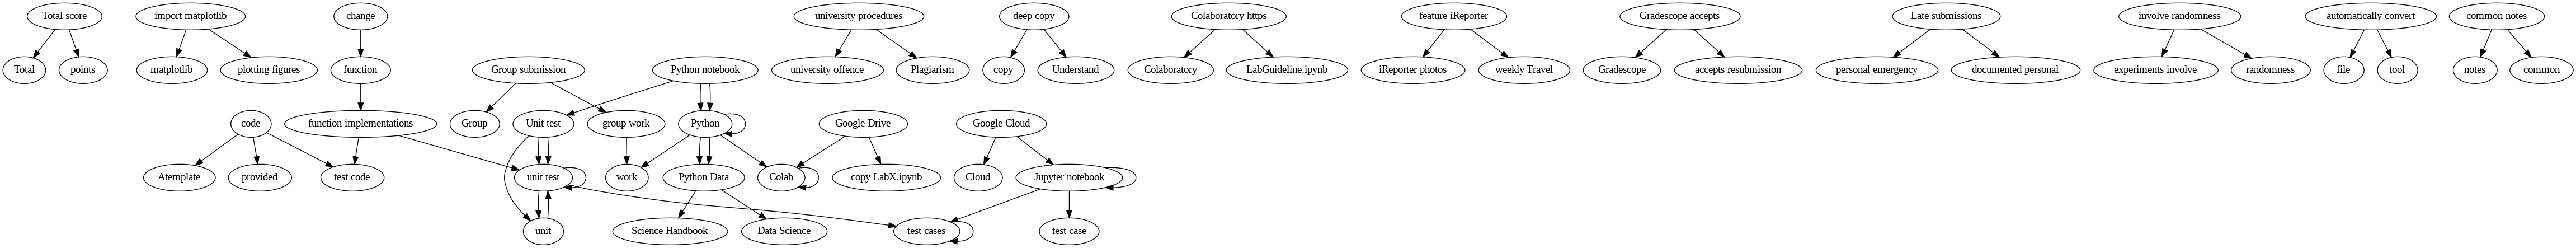

In [36]:
from graphviz import Digraph
from IPython.display import Image
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

dot = Digraph(comment="No-Loop Flowchart")

all_nodes = list(set([kw for para in titles_per_para for kw in para]))
list(map(lambda n: dot.node(n, n), all_nodes))

list(map(lambda para: list(map(lambda kw: dot.edge(para[0], kw), para[1:])), titles_per_para))

all_keywords_flat = [kw for para in titles_per_para for kw in para]
vectorizer = TfidfVectorizer().fit(all_keywords_flat)
embeddings = vectorizer.transform(all_keywords_flat).toarray()

similarity_matrix = cosine_similarity(embeddings)
threshold = 0.55

para_indices = np.repeat(np.arange(len(titles_per_para)), [len(p) for p in titles_per_para])

pairs = np.array(list(combinations(np.arange(len(all_keywords_flat)), 2)))

valid_pairs = pairs[
    (para_indices[pairs[:, 0]] != para_indices[pairs[:, 1]]) &
    (similarity_matrix[pairs[:, 0], pairs[:, 1]] > threshold)
]

list(map(lambda idx_pair: dot.edge(all_keywords_flat[idx_pair[0]], all_keywords_flat[idx_pair[1]]), valid_pairs))

dot.render("clean_no_loop_flowchart", format="png", cleanup=True)
Image("clean_no_loop_flowchart.png")
